# Explain Model Decision

**Learning outcomes**:  What is explainable AI? How do radiologists view the usefulness of the outputs of current explainable AI methods?

* Review paper explainable AI methods: Reyes, Mauricio, et al. "On the interpretability of artificial intelligence in radiology: challenges and opportunities." Radiology: artificial intelligence 2.3 (2020). https://pubs.rsna.org/doi/full/10.1148/ryai.2020190043

* Grad-CAM: Selvaraju, Ramprasaath R., et al. "Grad-cam: Visual explanations from deep networks via gradient-based localization." Proceedings of the IEEE international conference on computer vision. (2017). http://openaccess.thecvf.com/content_ICCV_2017/papers/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.pdf

* Integrated Gradients: Sundararajan, Mukund, Ankur Taly, and Qiqi Yan. "Axiomatic attribution for deep networks." International conference on machine learning. PMLR, (2017). http://proceedings.mlr.press/v70/sundararajan17a/sundararajan17a.pdf

In [1]:
import numpy as np
import monai
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from key2med.data.loader import CheXpertDataLoader, ColorCheXpertDataLoader
from key2med.models.CBRTiny import CBRTiny

## Standard Libraries for Explainable AI

In [2]:
import captum.attr as cap
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus
## https://pythonrepo.com/repo/jacobgil-pytorch-grad-cam
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Auxillary function for the plots / evaluation

In [3]:
# an auxillary plot-function
def plot3(base_img,attr1,attr2,attr3,titles,cmaps):
    plt.figure(figsize=(12,5))
    plt.subplot(131)
    plt.imshow(base_img,cmap="binary_r")
    plt.imshow(attr1,alpha=0.5,cmap=cmaps[0])
    plt.colorbar(shrink=0.6,aspect=20*0.7)
    plt.axis("off")
    plt.title(titles[0])
    plt.subplot(132)
    plt.imshow(base_img,cmap="binary_r")
    plt.imshow(attr2,alpha=0.5,cmap=cmaps[1])
    plt.colorbar(shrink=0.6,aspect=20*0.7)
    plt.axis("off")
    plt.title(titles[1])
    plt.subplot(133)
    plt.imshow(base_img,cmap="binary_r")
    plt.imshow(attr3,alpha=0.5,cmap=cmaps[2])
    plt.colorbar(shrink=0.6,aspect=20*0.7)
    plt.axis("off")
    plt.title(titles[2])
    plt.show()

def norm_1_1(X):
    new_X=X-np.min(X)
    new_X=new_X/np.max(new_X)*2
    new_X=new_X-1
    return new_X

# Define a evaluation function 
def eval_model(args, model, dataloader, do_squeeze=True):
    
    model.eval()

    preds = []
    y_preds = []
    y_true = []
    for batch in dataloader:
        inputs, targets = batch
        inputs = inputs.to(device)
        if do_squeeze: targets = targets.squeeze(dim=1)
        targets = targets.detach().cpu().numpy()
        y_true += list(targets)
        cur_preds = torch.nn.functional.softmax(model(inputs), dim=-1).detach().cpu().numpy()
        preds += list(cur_preds)
        y_preds += list( (cur_preds[:,1] > 0.5).astype(int))

    preds, y_preds, y_true =  np.asarray(preds), np.asarray(y_preds), np.asarray(y_true)
    if do_squeeze: y_true=y_true[:,all_labels.index(target)]
    
    return preds, y_preds, y_true


## Setup Dataset and load trained Model

Brief code snippets for a (very simple) dataloader, the model used (Resnet18 from torchvision)  and loading the parameters of the trained model.

In [4]:
# set constants like data dir and model dir
DATA_ROOT = '/data/MEDICAL/datasets/CheXpert_small/CheXpert-v1.0-small'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = "bonnhack_trained_models/training_output_150epochs/CBRTiny/"
target="Cardiomegaly"

In [ ]:
all_labels=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

args = {'seed': 42, # Set seed number if you want to reproduce results, else set it to None
    'data_dir': DATA_ROOT, # path to Chexpert data
    'class_positive': target, # Set class name you are working on for one vs. all classification
    'channel_in': 3, # Number of input channels (3 because of color for pre-trained imagenet)
    'freeze': True, # freeze model weights (if you use pre-trained model)
    'model_to_load_dir': None, # model path, if you want to continue training
    'output_dir': None,
    'num_epochs': 10, # number of epochs for training the model
    'max_steps': 100, # Total number of training steps. Low number for debugging, negative number for no limit.
    'do_train': True, 
    'max_dataloader_size': None, # Set to low number for debugging. default = None (no limit) 
    'view': 'Frontal', # For DataLoader, do you want to load Frontal, Lateral or both views?
    'batch_size': 1,
    'num_workers': 4, # For DataLoader
    'lr': 1e-3, # initial learning rate 
    'wd': 1e-6, # weight decay 
    'do_eval': True, # set to True if validation and test data should be evaluated after training
    'eval_steps': 500, # Number of batches/steps to eval. Default 500.
    'do_weight_loss_even': True, # Set to true if you want to use weighted loss function
    'do_upsample': True,
    'no_cuda': False,
    'do_early_stopping': False, # Set to true, if you want to use early stopping 
    'early_stopping_patience': 10 # Stop training if after x steps validation loss has not increased 
    }


# setup dataloader
dataloader = CheXpertDataLoader(
    data_path=args['data_dir'],
    batch_size=args['batch_size'],
    img_resize=224,
    channels=args['channel_in'],
    split_config="train_valid_test",
    do_random_transform=False,
    use_cache=False, #False
    in_memory=False, #True
    max_size= args['max_dataloader_size'],
    plot_stats=False,
    valid_views=[args['view']], 
    )


# load trained model
model = CBRTiny(num_classes=2, channel_in=args['channel_in']).to(device)

fully_trained=torch.load(model_dir+target+"/last_model.pth")
model.load_state_dict(fully_trained['model_state_dict'])
model.eval()

Many interpretability methods look at specific layers (Grad-CAM and such), here the target layer can be chosen out of the model layers

In [6]:
# define layers (for targeted interpretation)
layers,layer_names=[],[]
for name, layer in model.named_modules():
    if "conv" in name:
        layers.append(layer)
        layer_names.append(name)
        
    if "avgpool" in name:
        layers.append(layer)
        layer_names.append(name)

# last convolution for targeted interpretation (CAMs)
target_number=3
target_layer=layers[target_number] 
# last layer before classification (for latent space features)
target_layer_name=layer_names[-1] 

## Setup the Attribution Calculators

to use them later on the data samples

In [7]:
# setup captum attribution
saliency=cap.Saliency(model)
gbp=cap.GuidedBackprop(model)
guided_gradcam=cap.GuidedGradCam(model,target_layer)

# setup grad-cam 
gradcam = GradCAM(model=model, target_layers=[target_layer], use_cuda=True)
scorecam = ScoreCAM(model=model, target_layers=[target_layer], use_cuda=True)
gradcamplus = GradCAMPlusPlus(model=model, target_layers=[target_layer], use_cuda=True)

## Calculation and Visualization
Here the attribution of a few examples is calculated and visualized

In [10]:
# iterate through data and show attribution of N examples with prediction for target_class higher than threshold td
def attribution_plots(N,target_class,td,model,data):
    n1=0
    for n,val_data in enumerate(data):
            input_img = val_data[0].to(device)
            val_labels = val_data[1].long().to(device)
            val_labels = val_labels[:,all_labels.index(target)] 
            val_outputs = model(input_img)
            normed=torch.nn.functional.softmax(model(input_img), dim=-1).detach().cpu().numpy()[0]
            if normed[target_class]>=td:

                    n1+=1
                    print(n,normed)

                    # calculate attributions
                    sal_at=saliency.attribute(input_img,target=val_labels).cpu()
                    gbp_at=gbp.attribute(input_img,target=val_labels).cpu().detach().numpy()
                    g_grad_at=guided_gradcam.attribute(input_img,target=val_labels).cpu().detach().numpy()

                    grad_cam=gradcam(input_tensor=input_img, targets=None)
                    score_cam=scorecam(input_tensor=input_img, targets=None)
                    grad_plus_cam=gradcamplus(input_tensor=input_img, targets=None)

                    # visualisation
                    for i in range(val_data[0].shape[0]):
                        plot3(val_data[0][i,0],grad_cam[i],score_cam[i],grad_plus_cam[i],["Grad-CAM","Score-CAM","Grad-CAM++"],["Reds"]*3)
                        plot3(val_data[0][i,0],sal_at[i,0],norm_1_1(gbp_at[i,0]),norm_1_1(g_grad_at[i,0]),["Saliency","Guided Backpropagation","Guided Grad-CAM"],["Reds","seismic","seismic"])

            if n1>=N: break
 

 19%|█▉        | 6/32 [00:00<00:00, 52.91it/s]

10 [0.09530612 0.9046939 ]


100%|██████████| 32/32 [00:00<00:00, 56.62it/s]


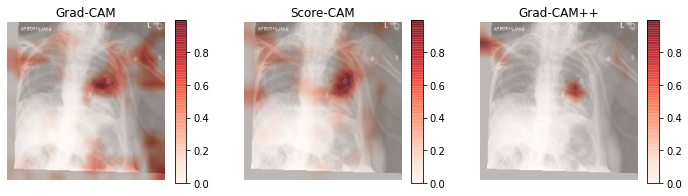

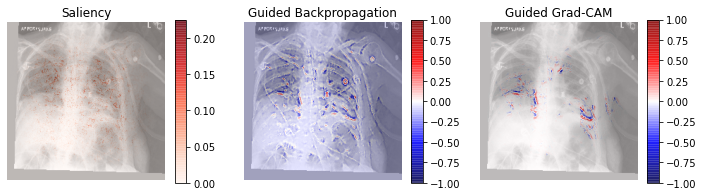

In [19]:
# does it look at the heart? or at support devices?

# iterate through data and show a few examples

attribution_plots(N=1,target_class=1,td=0.5,model=model,data=dataloader.validate)     

In [ ]:
# setup dataloader with other views
dataloader2 = CheXpertDataLoader(
    data_path=args['data_dir'],
    batch_size=args['batch_size'],
    img_resize=224,
    channels=args['channel_in'],
    split_config="train_valid",
    do_random_transform=False,
    use_cache=False, #False
    in_memory=False, #True
    max_size= 100,#args['max_dataloader_size'],
    plot_stats=False,
    print_stats=False,
    #valid_views=[args['view']], 
    )

100%|██████████| 32/32 [00:00<00:00, 56.94it/s]


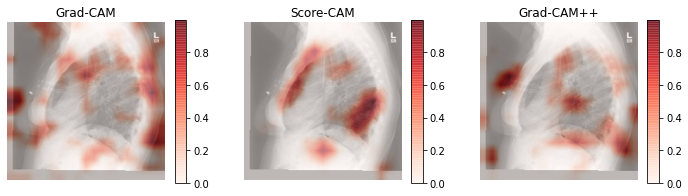

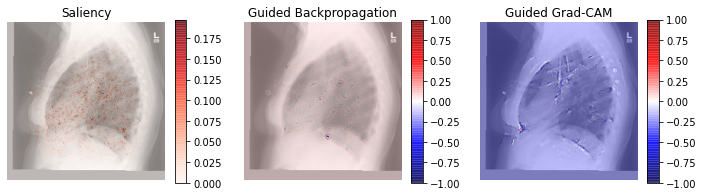

In [70]:
# but what would it look like on another view (this model was not trained on)

# does it look at the heart? Or just the same position as in the other view?

# iterate through data and show a few examples
show_examples=[39]#,43]
for n,val_data in enumerate(dataloader2.train):
    if n in show_examples:
        input_img = val_data[0].to(device)
        val_labels = val_data[1].long().to(device)
        val_labels = val_labels[:,all_labels.index(target)] 
        val_outputs = model(input_img)

        # calculate attributions
        sal_at=saliency.attribute(input_img,target=val_labels).cpu()
        gbp_at=gbp.attribute(input_img,target=val_labels).cpu().detach().numpy()
        g_grad_at=guided_gradcam.attribute(input_img,target=val_labels).cpu().detach().numpy()

        grad_cam=gradcam(input_tensor=input_img, targets=None)
        score_cam=scorecam(input_tensor=input_img, targets=None)
        grad_plus_cam=gradcamplus(input_tensor=input_img, targets=None)

        # visualisation
        for i in range(val_data[0].shape[0]):
            plot3(val_data[0][i,0],grad_cam[i],score_cam[i],grad_plus_cam[i],["Grad-CAM","Score-CAM","Grad-CAM++"],["Reds"]*3)
            plot3(val_data[0][i,0],sal_at[i,0],norm_1_1(gbp_at[i,0]),norm_1_1(g_grad_at[i,0]),["Saliency","Guided Backpropagation","Guided Grad-CAM"],["Reds","seismic","seismic"])
        break

## Latent Space Features


In [10]:
def extract_feats(pre_model,dataloader,inter_layer):

    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    for name, layer in pre_model.named_modules():
        layer.register_forward_hook(get_activation(name))

    feats=[]
    for batch in dataloader:
        inputs, targets = batch
        inputs = inputs.to(device)
        pre_output=pre_model(inputs)

        feats.append(activation[inter_layer].cpu().numpy().ravel())#[:400])	
    feats=np.asarray(feats)
    return feats


def make_2_plots(X1,X2,legend_elements,colors):
    # plot two main components
    plt.scatter(X1[0],X1[1], c=colors)
    plt.title("2 main principal components")
    plt.legend(handles=legend_elements)
    plt.show()

    plt.scatter(X2[0],X2[1], c=colors)
    plt.title("t-SNE")
    plt.legend(handles=legend_elements)
    plt.show()

def plot_latent_space(args,model,target_layer_name,dataloader,do_both=True):

    # extract latent space features
    feats=extract_feats(model,dataloader,target_layer_name)

    print(feats.shape)

    # use PCA to reduce number of features
    pca=PCA(n_components=50)
    new_feats=pca.fit_transform(feats)
    print(new_feats.shape)

    #plt.plot(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_)
    #plt.show()


    # use t-SNE to viszualize in 2d
    embedded = TSNE().fit_transform(new_feats)
    print(embedded.shape)

    preds, y_preds, y_true = eval_model(args, model, dataloader, False)

    labels=["Predicted 0","Predicted 1"]
    colors=["b" if y_preds[i]==0 else "r" for i in range(len(y_preds))]

    legend_elements = [Line2D([0], [0], marker='o', color='w', label=labels[0], markerfacecolor='b', markersize=15), 
        Line2D([0], [0], marker='o', color='w', label=labels[1], markerfacecolor='r', markersize=15)]

    make_2_plots([new_feats[:, 0], new_feats[:, 1]],[embedded[:, 0], embedded[:, 1]],legend_elements,colors)
    
    if do_both:
        labels=["Correct 0", "Correct 1", "Incorrect 0", "Incorrect 1"]
        #colors=["b" for i in range(len(y_preds)) if (y_preds[i]==0 and y_true[i]==0) else "g" if (y_preds[i]==1 and y_true[i]==1) else "r" if (y_preds[i]==0 and y_true[i]==1) else "orange" if (y_preds[i]==1 and y_true[i]==0)]
        combinations = [(0,0),(0,1),(1,0),(1,1)]
        cs = ["b","r","orange","g"]
        colors=[cs[combinations.index((y_preds[i],np.around(y_true[i])))] for i in range(len(y_preds))]

        legend_elements = [Line2D([0], [0], marker='o', color='w', label=labels[0], markerfacecolor='b', markersize=15), 
            Line2D([0], [0], marker='o', color='w', label=labels[1], markerfacecolor='g', markersize=15), 
            Line2D([0], [0], marker='o', color='w', label=labels[2], markerfacecolor='r', markersize=15), 
            Line2D([0], [0], marker='o', color='w', label=labels[3], markerfacecolor='orange', markersize=15)]            
        make_2_plots([new_feats[:, 0], new_feats[:, 1]],[embedded[:, 0], embedded[:, 1]],legend_elements,colors)


In [ ]:
#plot_latent_space(args,model,target_layer_name,dataloader.validate,eval_model)

In [32]:
# only look at subset with confident decision

# select a subset containing N correctly predicted samples (over threshold cd) of each class
cd=0.6
N=400   
confident_data=[]
n_0,n_1=0,0
p_n=[]
for inputs, labels in dataloader.validate:
    labels = labels[:,all_labels.index(target)]
    if labels==0 and n_0<N: 
        normed=torch.nn.functional.softmax(model(inputs.to(device)), dim=-1).detach().cpu().numpy()[0]
        if normed[int(labels)]>=cd:
            confident_data.append((inputs.cpu(),labels.cpu()))
            p_n.append(normed[int(labels)])
            n_0+=1
    if labels==1 and n_1<N: 
        normed=torch.nn.functional.softmax(model(inputs.to(device)), dim=-1).detach().cpu().numpy()[0]
        if normed[int(labels)]>=cd:
            confident_data.append((inputs.cpu(),labels.cpu()))
            p_n.append(normed[int(labels)])
            n_1+=1
    if n_0>=N and n_1>=N: break
            
print(len(p_n),n_0,n_1)


800 400 400


(800, 512)
(800, 50)
(800, 2)


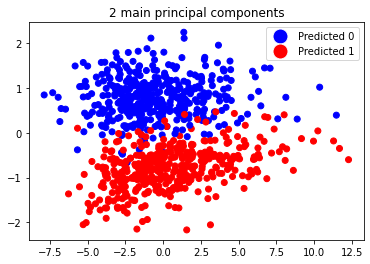

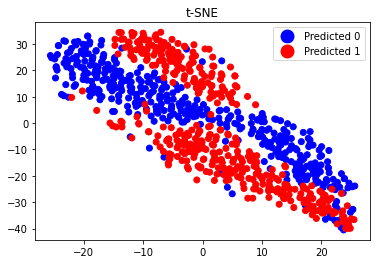

In [33]:
plot_latent_space(args,model,target_layer_name,confident_data,False)

## Visualize most confident Examples

In [34]:
# only MOST confident samples (confidence higher than threshold td)
td=0.99
most_confident_data=[]
for i in range(len(p_n)):
    if p_n[i]>td:
        most_confident_data.append(confident_data[i])
print(len(most_confident_data))

659


### Positive Examples (here: Cardiomegaly)

 19%|█▉        | 6/32 [00:00<00:00, 55.96it/s]

135 [9.994061e-05 9.999001e-01]


100%|██████████| 32/32 [00:00<00:00, 57.01it/s]


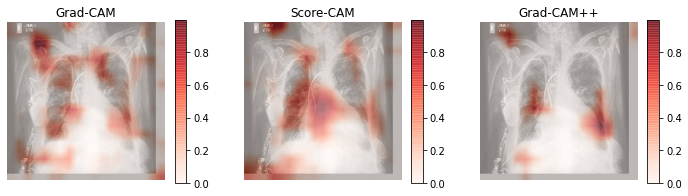

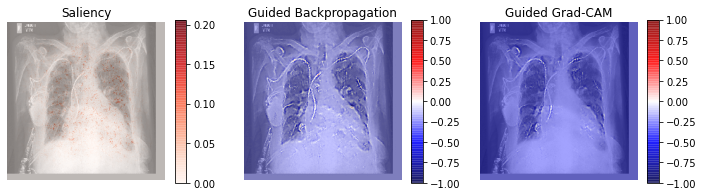

In [27]:
attribution_plots(N=1,target_class=1,td=1-1e-4,model=model,data=dataloader.validate)              

### Negative Examples (here: No Cardiomegaly)

 19%|█▉        | 6/32 [00:00<00:00, 53.25it/s]

1 [9.999685e-01 3.149837e-05]


100%|██████████| 32/32 [00:00<00:00, 56.09it/s]


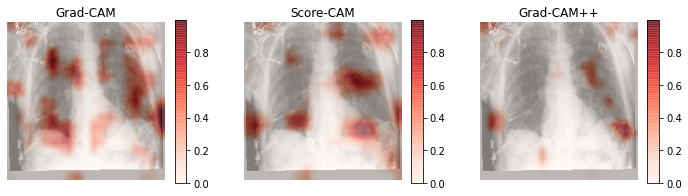

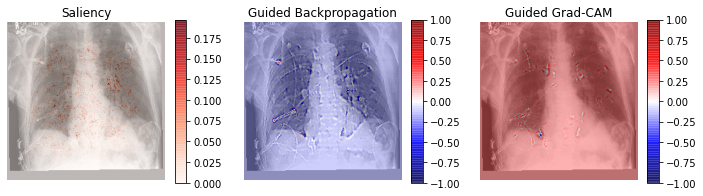

In [39]:
attribution_plots(N=1,target_class=0,td=1-1e-4,model=model,data=dataloader.validate)       

### Latent Space Features

(659, 512)
(659, 50)
(659, 2)


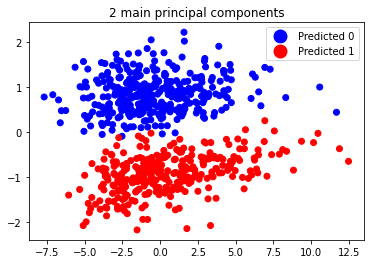

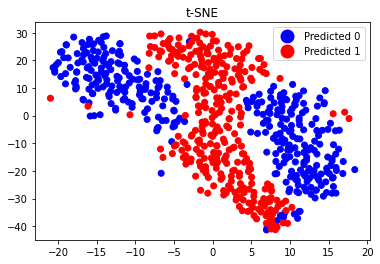

In [45]:
plot_latent_space(args,model,target_layer_name,most_confident_data,False)

## Interpretation
The results of the attribution methods sometimes look different. 

**Questions**:

- what kind of interpretability is 'correct' ?
- how can the results be interpreted (ML & medical) ?
- can you use this information to improve the model ?

Reading to support the discussion:

* Xie, Yao, et al. "CheXplain: enabling physicians to explore and understand data-driven, AI-enabled medical imaging analysis." Proceedings of the 2020 CHI Conference on Human Factors in Computing Systems. 2020. https://arxiv.org/pdf/2001.05149.pdf
* Ghassemi, Marzyeh, Luke Oakden-Rayner, and Andrew L. Beam. "The false hope of current approaches to explainable artificial intelligence in health care." The Lancet Digital Health 3.11 (2021). https://www.thelancet.com/journals/landig/article/PIIS2589-7500(21)00208-9/fulltext
* Reyes, Mauricio, et al. "On the interpretability of artificial intelligence in radiology: challenges and opportunities." Radiology: artificial intelligence 2.3 (2020). https://pubs.rsna.org/doi/full/10.1148/ryai.2020190043
* https://distill.pub/2017/feature-visualization/